In [28]:
import example_utils as utils
import pandas as pd
caution_multipliers = [
    [0.125, 0.125, 0.25, 0.5],
    [0.125, 0.125, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 1.0, 1.0],
    [1.0, 1.0, 0.25, 0.5],
]
N = len(caution_multipliers)

param_list = []

for i in range(N):
    params = utils.get_baseline_parameters()
    params.set_param( "n_total", 10000 )

    params.set_param( "test_on_symptoms", 1 )
    params.set_param( "testing_symptoms_time_on", 1 )
    params.set_param( "trace_on_positive", 1 )
    params.set_param( "app_turn_on_time", 1 )
    params.set_param( "intervention_start_time", 1 )
    params.set_param( "tracing_network_depth", 1 )
    params.set_param( "quarantine_on_traced", 1 )

    params.set_param( "self_quarantine_fraction", 0 )
    params.set_param( "quarantine_household_on_positive", 0 )

    params.set_param( "quarantine_dropout_self", 0 )
    params.set_param( "quarantine_dropout_traced_symptoms", 0 )
    params.set_param( "quarantine_dropout_traced_positive", 0 )
    params.set_param( "quarantine_dropout_positive", 0 )
    params.set_param( "quarantine_compliance_traced_symptoms", 0 ) # no effect??
    params.set_param( "quarantine_compliance_traced_positive", 0 ) # same

    params.set_param( "test_release_on_negative", 0 )
    params.set_param( "soft_quarantine_on", 1 )
    params.set_param( "novid_quarantine_length", 7 )

    params.set_param( "novid_phone_fraction", 0.5 )
    params.set_param( "app_phone_fraction", 0.5 )
    
    params.set_param( "novid_soft_multiplier_1", caution_multipliers[i][0] )
    params.set_param( "novid_soft_multiplier_2", caution_multipliers[i][1] )
    params.set_param( "novid_soft_multiplier_3", caution_multipliers[i][2] )
    params.set_param( "novid_soft_multiplier_4", caution_multipliers[i][3] )
    
    #params.set_param( "mean_random_interactions_child", 0 )
    #params.set_param( "mean_random_interactions_adult", 0 )
    #params.set_param( "mean_random_interactions_elderly", 0 )
    #params.set_param( "mean_work_interactions_child", 12 )
    #params.set_param( "mean_work_interactions_adult", 11 )
    #params.set_param( "mean_work_interactions_elderly", 6 )
    
    param_list.append(params)

In [29]:
suffixes = [
    "_novid",
    "_contact_tracing",
    "_no_intervention",
    "_contact_tracing_strict",
    "_novid_2_3",
]
suffixes2 = [
    "_novid",
    "_contact_tracing",
    "_no_intervention",
]
def suffix_list(s):
    return [s+suf for suf in suffixes]
def suffix_list2(s):
    return [s+suf for suf in suffixes2]

In [30]:
from functools import reduce
result_list = [0]*N

for i in range(N):
    print(f"Starting simulation {i}")
    sim = utils.get_simulation(param_list[i])
    sim.steps(100)
    result_list[i] = pd.DataFrame(sim.results).add_suffix(suffixes[i])
timeseries = reduce(lambda a,b: pd.merge(a,b, how="outer", left_index=True, right_index=True), result_list)

Starting simulation 0
Starting simulation 1
Starting simulation 2
Starting simulation 3
Starting simulation 4


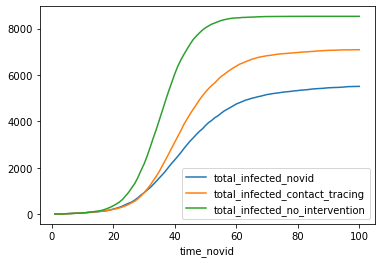

In [32]:
timeseries.plot( x = "time_novid", y = suffix_list2("total_infected"))
#timeseries.plot( x = "time_novid", y = suffix_list2("n_cases"))